# STAT 5205/4205 Final Project (Python)
## Global Temperature Anomaly vs Global Mean Sea Level (with Evaporation)

- `Global_TAVG_monthly.txt` (temperature anomaly, monthly)
- `GMSL_TPJAOS_5.2.txt` (GMSL product, monthly)
- `GLEAM_global_monthly_evaporation.csv` (monthly global evaporation)
- CO2

This notebook:

1. Loads temperature anomaly and GMSL, aligns to **calendar months**, and creates a clean monthly panel.
2. Adds **evaporation** (note: your evaporation file starts in 2003, so models that include evaporation will use a shorter sample).
3. Creates **≥ 4 figures**, including a **3D-style** bubble plot (color + size).
4. Fits OLS regressions and reports **Newey–West (HAC, lag=12)** standard errors.

Outputs are saved to:
- Figures: `pic/`
- Tables: `out/`


## 0) Setup and paths

### Edit paths (Windows)
You provided these Windows paths:

- `C:\Users\F\Desktop\5205 final project\GLEAM_global_monthly_evaporation.csv`
- `C:\Users\F\Desktop\5205 final project\GMSL_TPJAOS_5.2.txt`
- `C:\Users\F\Desktop\5205 final project\Global_TAVG_monthly.txt`

In Python, use **raw strings** (prefix with `r"..."`) so backslashes don’t get interpreted as escapes.

This notebook will:
- try your Windows paths first
- if not found, fall back to local filenames in the current folder


In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_hac

TEMP_PATH = "Global_TAVG_monthly.txt"
GMSL_PATH = "GMSL_TPJAOS_5.2.txt"
EVAP_PATH = "GLEAM_global_monthly_evaporation.csv"
CO2_PATH = "co2_mm_mlo.csv"

# Normal CDF helper (for HAC p-values)
try:
    from scipy.stats import norm
    _norm_cdf = norm.cdf
except Exception:
    import math
    def _norm_cdf(x):
        x = np.asarray(x, dtype=float)
        return 0.5 * (1.0 + np.vectorize(math.erf)(x / np.sqrt(2.0)))

## 1) Parsing helper functions

### Monthly join key
We represent each month by the **15th day of that month** (`YYYY-MM-15`) to make merging simple and consistent.

### Temperature file format (Berkeley Earth)
Your temperature file includes many header lines (starting with `%`) and then rows like:

`Year  Month  Monthly_Anomaly  ...`

We only need:
- year
- month
- monthly anomaly

### GMSL file format (NASA GSFC / PO.DAAC v5.2)
The header describes the columns. We use:
- **column 3**: year + fraction of year (mid-cycle)
- **column 12**: GMSL (mm), smoothed, GIA applied, annual/semiannual removed

We convert `year + fraction` into an approximate calendar month.


In [7]:
import re

def month_key(year: int, month: int) -> pd.Timestamp:
    # Standard monthly key = 15th day of the month.
    return pd.Timestamp(year=int(year), month=int(month), day=15)

def read_temperature_anomaly_txt(path: Path) -> pd.DataFrame:
    '''
    Parse monthly temperature anomaly from a Berkeley Earth-style file.

    We keep lines that look like:
      YYYY  M  <number>
    and take the third number as the monthly anomaly.
    '''
    rows = []
    pat = re.compile(r"^\s*(\d{4})\s+(\d{1,2})\s+([-+]?\d+(\.\d+)?([eE][-+]?\d+)?)")
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = pat.match(line)
            if m:
                year = int(m.group(1))
                month = int(m.group(2))
                anom = float(m.group(3))
                rows.append((month_key(year, month), year, month, anom))
    df = pd.DataFrame(rows, columns=["date", "year", "month", "temp_anom"])
    if df.empty:
        raise ValueError("No temperature rows parsed. Check file path/format.")
    return df.sort_values("date").reset_index(drop=True)

def read_gmsl_txt_yearfrac(path: Path, yearfrac_col_idx=2, gmsl_col_idx=11) -> pd.DataFrame:
    '''
    Parse the GMSL text file.

    - yearfrac_col_idx=2 means "3rd column" (0-based index)
    - gmsl_col_idx=11 means "12th column" (0-based index)

    Returns monthly series with columns: [date, gmsl_mm]
    '''
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            # Skip header lines like "HDR ..."
            if s.startswith("HDR"):
                continue
            # Keep numeric-ish lines
            if not re.match(r"^[0-9\-\+\.]", s):
                continue

            parts = re.split(r"\s+", s)
            if len(parts) <= max(yearfrac_col_idx, gmsl_col_idx):
                continue

            try:
                year_frac = float(parts[yearfrac_col_idx])
                gmsl_mm = float(parts[gmsl_col_idx])
            except ValueError:
                continue

            # Some files use 99900.000 as missing flag; drop those if present
            if abs(gmsl_mm - 99900.0) < 1e-6:
                continue

            year = int(np.floor(year_frac))
            frac = year_frac - year

            # Approx date: Jan 1 + frac*365.25 days -> month -> set day=15
            date_raw = pd.Timestamp(year=year, month=1, day=1) + pd.to_timedelta(int(round(frac * 365.25)), unit="D")
            date = pd.Timestamp(year=date_raw.year, month=date_raw.month, day=15)

            rows.append((date, gmsl_mm))

    df = pd.DataFrame(rows, columns=["date", "gmsl_mm"])
    if df.empty:
        raise ValueError("No GMSL rows parsed. Check file path/format/column indices.")
    # Average duplicates within month (can happen due to rounding)
    df = df.groupby("date", as_index=False)["gmsl_mm"].mean()
    return df.sort_values("date").reset_index(drop=True)

def read_evaporation_csv(path: Path) -> pd.DataFrame:
    '''
    Read evaporation CSV.
    Your file uses columns: year, month, evaporation.
    '''
    df = pd.read_csv(path)
    required = {"year", "month", "evaporation"}
    if not required.issubset(df.columns):
        raise ValueError(f"Evap file must contain {sorted(required)}. Found: {list(df.columns)}")

    out = df.copy()
    out["year"] = out["year"].astype(int)
    out["month"] = out["month"].astype(int)
    out["evap"] = pd.to_numeric(out["evaporation"], errors="coerce")
    out["date"] = [month_key(y, m) for y, m in zip(out["year"], out["month"])]

    out = out[["date", "evap"]].dropna().sort_values("date").reset_index(drop=True)
    return out

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    # Add decade labels, a monthly trend index, and a bubble-size index.
    out = df.copy()
    out["year"] = out["date"].dt.year
    out["month"] = out["date"].dt.month
    out["decade"] = (out["year"] // 10 * 10).astype(int).astype(str) + "s"
    out["trend"] = (out["date"] - out["date"].min()).dt.days / 30.437  # ~ months since start

    # Bubble size: scale to [1, 6]
    t = out["date"].astype("int64")
    out["t_idx"] = 1 + 5 * (t - t.min()) / (t.max() - t.min())
    return out

def read_co2_mlo_csv(path: Path) -> pd.DataFrame:
    """
    Read NOAA Mauna Loa monthly CO2 data (co2_mm_mlo.csv).

    Returns:
        DataFrame with columns:
        - date
        - co2_avg (raw monthly mean, ppm)
        - co2_ds  (deseasonalized, ppm)
    """
    df = pd.read_csv(path, comment="#")

    required = {"year", "month", "average", "deseasonalized"}
    if not required.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required}")

    out = df.copy()
    out["year"] = out["year"].astype(int)
    out["month"] = out["month"].astype(int)

    out["co2_avg"] = pd.to_numeric(out["average"], errors="coerce")
    out["co2_ds"]  = pd.to_numeric(out["deseasonalized"], errors="coerce")

    out["date"] = [
        month_key(y, m)
        for y, m in zip(out["year"], out["month"])
    ]

    out = (
        out[["date", "co2_avg", "co2_ds"]]
        .dropna()
        .sort_values("date")
        .reset_index(drop=True)
    )

    if out.empty:
        raise ValueError("No valid CO2 rows parsed.")

    return out


## 2) Load data


In [8]:
temp = read_temperature_anomaly_txt(TEMP_PATH)
gmsl = read_gmsl_txt_yearfrac(GMSL_PATH)
evap = read_evaporation_csv(EVAP_PATH)
co2 = read_co2_mlo_csv(CO2_PATH)

print("Temp rows:", len(temp), "range:", temp["date"].min(), "to", temp["date"].max())
print("GMSL rows:", len(gmsl), "range:", gmsl["date"].min(), "to", gmsl["date"].max())
print("Evap rows:", len(evap), "range:", evap["date"].min(), "to", evap["date"].max())
print("CO2 rows:", len(co2), "range:", co2["date"].min(), "to", co2["date"].max())

display(temp.head())
display(gmsl.head())
display(evap.head())
display(co2.head())


Temp rows: 2109 range: 1850-01-15 00:00:00 to 2025-09-15 00:00:00
GMSL rows: 389 range: 1993-01-15 00:00:00 to 2025-05-15 00:00:00
Evap rows: 264 range: 2003-01-15 00:00:00 to 2024-12-15 00:00:00
CO2 rows: 813 range: 1958-03-15 00:00:00 to 2025-11-15 00:00:00


,date,year,month,temp_anom
0,1850-01-15,1850,1,-0.469
1,1850-02-15,1850,2,-0.660
2,1850-03-15,1850,3,-0.427
3,1850-04-15,1850,4,-0.810
4,1850-05-15,1850,5,-0.375


,date,gmsl_mm
0,1993-01-15,-38.290000
1,1993-02-15,-36.890000
2,1993-03-15,-33.940000
3,1993-04-15,-33.013333
4,1993-05-15,-32.383333


,date,evap
0,2003-01-15,22.161547
1,2003-02-15,21.372425
2,2003-03-15,25.728031
3,2003-04-15,30.654030
4,2003-05-15,37.179916


,date,co2_avg,co2_ds
0,1958-03-15,315.71,314.44
1,1958-04-15,317.45,315.16
2,1958-05-15,317.51,314.69
3,1958-06-15,317.27,315.15
4,1958-07-15,315.87,315.20


## 3) Build panels (two samples)

Because evaporation starts later (in your file it begins in 2003), we build:

### Panel A (baseline, long sample)
- Inner-join **temperature + GMSL**
- Keep 1993-01 to 2024-12 (matches your Part 1 write-up window)

### Panel B (with evaporation)
- Inner-join **temperature + GMSL + evaporation**
- This will start at the first month where evaporation exists (≈ 2003)


In [9]:
# Panel A: Temp + GMSL
df_base = (
    temp.merge(gmsl, on="date", how="inner")
        .sort_values("date")
        .reset_index(drop=True)
)
df_base = df_base[(df_base["date"] >= "1993-01-01") & (df_base["date"] <= "2024-12-31")].copy()
df_base = add_time_features(df_base)

# Panel B: Full
df_evap = (
    temp.merge(gmsl, on="date", how="inner")
        .merge(evap, on="date", how="inner")
        .merge(co2, on="date", how="inner")
        .sort_values("date")
        .reset_index(drop=True)
)
df_evap = df_evap[(df_evap["date"] >= "1993-01-01") & (df_evap["date"] <= "2024-12-31")].copy()
df_evap = add_time_features(df_evap)

print("Panel A (Temp+GMSL) n =", len(df_base), "range:", df_base["date"].min(), "to", df_base["date"].max())
print("Panel B (Full)     n =", len(df_evap), "range:", df_evap["date"].min(), "to", df_evap["date"].max())


Panel A (Temp+GMSL) n = 384 range: 1993-01-15 00:00:00 to 2024-12-15 00:00:00
Panel B (Full)     n = 264 range: 2003-01-15 00:00:00 to 2024-12-15 00:00:00


## 4) Descriptive statistics (exportable)

We compute summary stats for:
- Panel A: Temp anomaly, GMSL
- Panel B: FUll model

Saved to:
- `out/desc_stats_panelA.csv`
- `out/desc_stats_panelB.csv`


In [11]:
def desc_stats(s: pd.Series) -> dict:
    s = s.dropna()
    return {
        "Count": len(s),
        "Mean": s.mean(),
        "Std": s.std(ddof=1),
        "Min": s.min(),
        "25%": s.quantile(0.25),
        "50%": s.quantile(0.50),
        "75%": s.quantile(0.75),
        "Max": s.max(),
    }

# desc_A = pd.DataFrame({
#     "Temperature Anomaly (°C)": desc_stats(df_base["temp_anom"]),
#     "GMSL (mm)": desc_stats(df_base["gmsl_mm"]),
# }).T.round(3)

desc_B = pd.DataFrame({
    "Temperature Anomaly (°C)": desc_stats(df_evap["temp_anom"]),
    "GMSL (mm)": desc_stats(df_evap["gmsl_mm"]),
    "Evaporation": desc_stats(df_evap["evap"]),
    "CO2": desc_stats(df_evap["co2_avg"]),

}).T.round(3)

# display(desc_A)
display(desc_B)

# desc_A.to_csv("out/desc_stats_panelA.csv")
desc_B.to_csv("out/desc_stats_panelB.csv")
# print("Saved: out/desc_stats_panelA.csv, out/desc_stats_panelB.csv")


,Count,Mean,Std,Min,25%,50%,75%,Max
Temperature Anomaly (°C),264.0,0.795,0.224,0.250,0.636,0.763,0.914,1.449
GMSL (mm),264.0,30.667,23.909,-4.630,8.102,28.332,53.634,75.327
Evaporation,264.0,30.737,7.528,20.774,23.427,28.965,38.119,44.817
CO2,264.0,398.736,14.796,373.310,386.188,397.585,411.492,426.910


## 5) Figures (≥ 4, and one is multi-dimensional)

We save figures to `pic/`.

Planned figures:
1. GMSL time series (Panel A)
2. Temperature anomaly time series (Panel A)
3. Evaporation time series (Panel B)
4. Scatter: GMSL vs Temp (Panel A) + fitted line
5. Bubble plot (Panel A): color=decade, size=time ✅ multi-dimensional


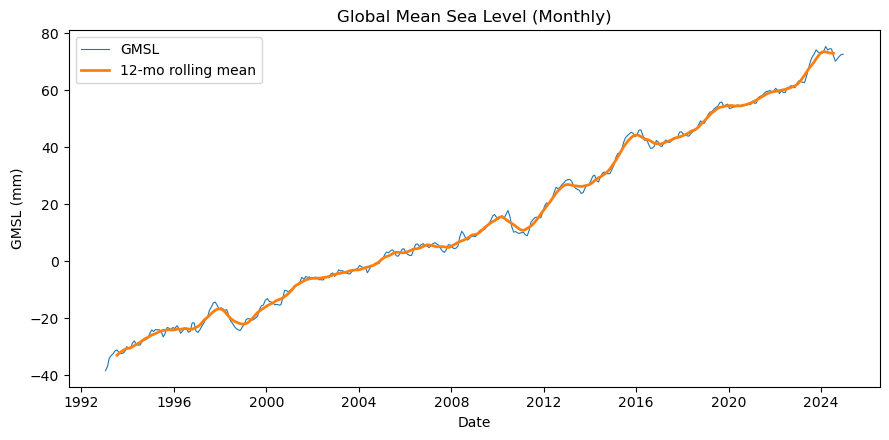

In [6]:
# Fig1: GMSL time series (Panel A) + 12-month rolling mean
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(df_base["date"], df_base["gmsl_mm"], linewidth=0.8, label="GMSL")
roll = df_base.set_index("date")["gmsl_mm"].rolling(12, center=True).mean()
ax.plot(roll.index, roll.values, linewidth=2.0, label="12-mo rolling mean")
ax.set_title("Global Mean Sea Level (Monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("GMSL (mm)")
ax.legend()
fig.tight_layout()
fig.savefig("pic/fig1_gmsl_ts.png", dpi=300)
plt.show()


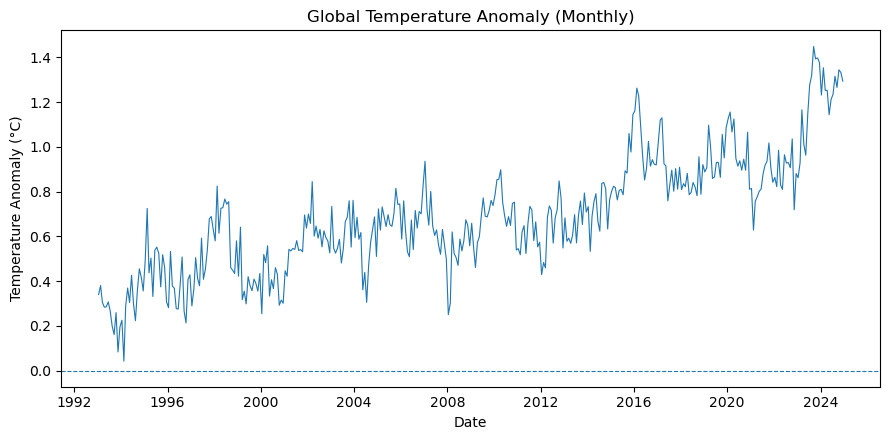

In [7]:
# Fig2: Temperature anomaly time series (Panel A)
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.axhline(0, linestyle="--", linewidth=0.8)
ax.plot(df_base["date"], df_base["temp_anom"], linewidth=0.8)
ax.set_title("Global Temperature Anomaly (Monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature Anomaly (°C)")
fig.tight_layout()
fig.savefig("pic/fig2_temp_ts.png", dpi=300)
plt.show()


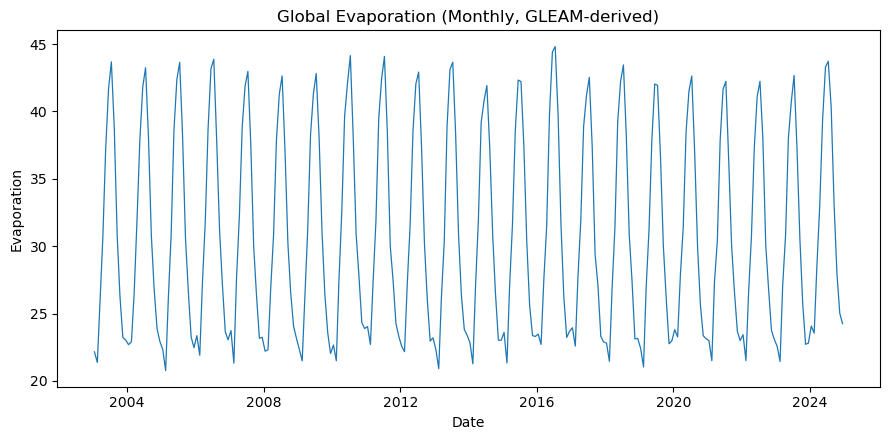

In [8]:
# Fig3: Evaporation time series (Panel B)
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(df_evap["date"], df_evap["evap"], linewidth=0.9)
ax.set_title("Global Evaporation (Monthly, GLEAM-derived)")
ax.set_xlabel("Date")
ax.set_ylabel("Evaporation")
fig.tight_layout()
fig.savefig("pic/fig3_evap_ts.png", dpi=300)
plt.show()


### Fig4: Scatter + fitted line (Panel A)

We fit the simple model:

\[
\text{GMSL}_t = \alpha + \beta \cdot \text{TempAnom}_t + \varepsilon_t.
\]

and annotate the slope (mm/°C).


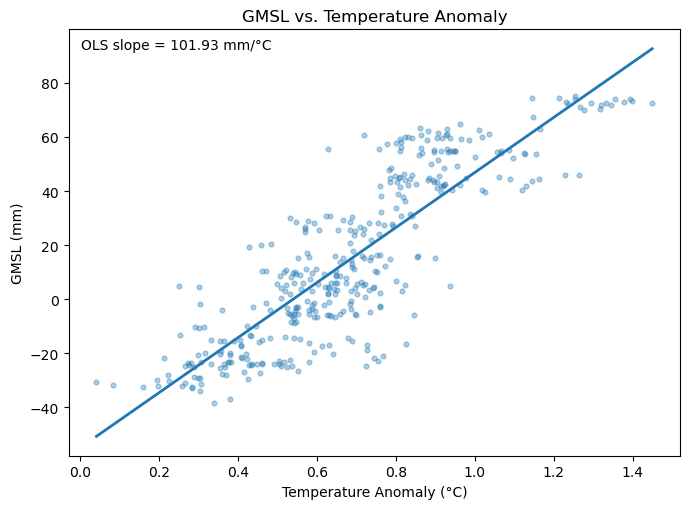

In [13]:
X1 = sm.add_constant(df_base[["temp_anom"]])
m1 = sm.OLS(df_base["gmsl_mm"], X1).fit()
slope = m1.params["temp_anom"]

fig, ax = plt.subplots(figsize=(7, 5.2))
ax.scatter(df_base["temp_anom"], df_base["gmsl_mm"], alpha=0.35, s=12)

xgrid = np.linspace(df_base["temp_anom"].min(), df_base["temp_anom"].max(), 200)
yhat = m1.params["const"] + slope * xgrid
ax.plot(xgrid, yhat, linewidth=2.0)

ax.set_title("GMSL vs. Temperature Anomaly")
ax.set_xlabel("Temperature Anomaly (°C)")
ax.set_ylabel("GMSL (mm)")
ax.text(0.02, 0.98, f"OLS slope = {slope:.2f} mm/°C", transform=ax.transAxes, va="top")

fig.tight_layout()
fig.savefig("pic/fig4_scatter_gmsl_temp.png", dpi=300)
plt.show()


### Fig5: Multi-dimensional bubble plot (Panel A)

- x = temperature anomaly
- y = GMSL
- color = decade
- size = time progression

✅ This satisfies the “≥ 3 variables in one figure” requirement.


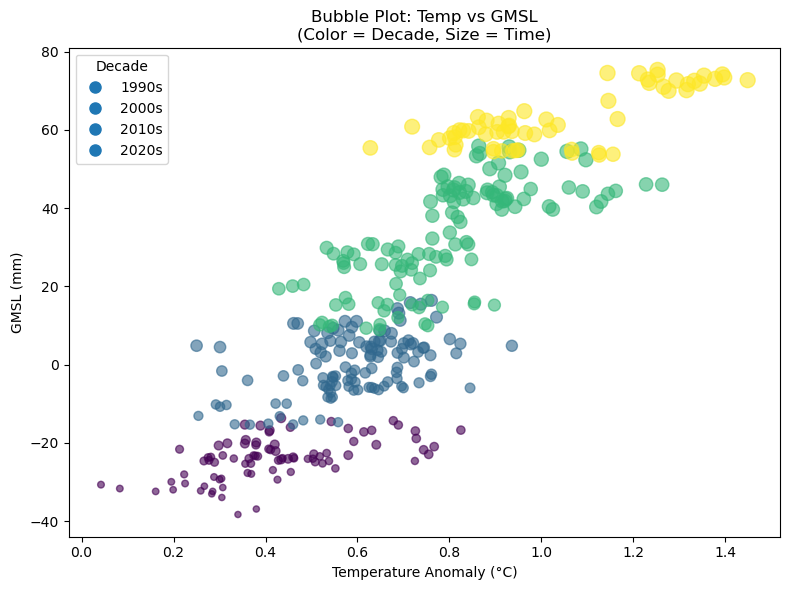

In [14]:
decades = sorted(df_base["decade"].unique())
decade_to_int = {d:i for i,d in enumerate(decades)}
cvals = df_base["decade"].map(decade_to_int).values

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_base["temp_anom"], df_base["gmsl_mm"],
           c=cvals, s=20*df_base["t_idx"], alpha=0.6)

ax.set_title("Bubble Plot: Temp vs GMSL\n(Color = Decade, Size = Time)")
ax.set_xlabel("Temperature Anomaly (°C)")
ax.set_ylabel("GMSL (mm)")

handles = [plt.Line2D([0],[0], marker="o", linestyle="", markersize=8, label=d) for d in decades]
ax.legend(handles=handles, title="Decade", loc="best", frameon=True)

fig.tight_layout()
fig.savefig("pic/fig5_bubble_3vars.png", dpi=300)
plt.show()


## 6) Regressions + HAC(Newey–West, lag=12) + 假设检验（含年代差异与交互项）

我们做两类样本：

- **Panel A（长样本）**：Temp + GMSL（1993–2024）
- **Panel B（短样本）**：Temp + GMSL + Evap（因为蒸发数据起始较晚，所以样本更短；后续“协变量显著性/交互项/年代差异”都基于 Panel B）

本节输出：
- 回归表（OLS 与 HAC）
- 年代差异与交互项的整体显著性（Wald test，使用 HAC 协方差）


In [11]:
def ols_with_hac(y: pd.Series, X: pd.DataFrame, lags: int = 12):
    '''
    Fit OLS and attach HAC(Newey-West) standard errors (lag=lags).

    返回：
      - model: statsmodels OLS 拟合结果
      - tab: 系数表（包含 OLS 与 HAC 的 SE / t / p）
      - V_hac: HAC 协方差矩阵（后面做整体 Wald 检验用）
    '''
    Xc = sm.add_constant(X, has_constant="add")
    model = sm.OLS(y, Xc).fit()

    V_hac = cov_hac(model, nlags=lags)
    se_hac = np.sqrt(np.diag(V_hac))

    t_hac = model.params / se_hac
    p_hac = 2 * (1 - _norm_cdf(np.abs(t_hac)))  # asymptotic normal approx

    tab = pd.DataFrame({
        "coef": model.params,
        "SE (OLS)": model.bse,
        "t (OLS)": model.tvalues,
        "p (OLS)": model.pvalues,
        "SE (HAC)": se_hac,
        "t (HAC)": t_hac,
        "p (HAC)": p_hac,
    })
    return model, tab, V_hac

# =========================
# Panel A（长样本）：温度 + 海平面
# =========================
A1_model, A1_tab, A1_V = ols_with_hac(df_base["gmsl_mm"], df_base[["temp_anom"]], lags=12)
A2_model, A2_tab, A2_V = ols_with_hac(df_base["gmsl_mm"], df_base[["temp_anom", "trend"]], lags=12)

# =========================
# Panel B（短样本）：温度 + 海平面 + 蒸发
# 后面“协变量显著性/年代差异/交互项”都基于这一份样本
# =========================
d = df_evap.copy()

# (B1) 最基础：Temp + Evap
B1_model, B1_tab, B1_V = ols_with_hac(d["gmsl_mm"], d[["temp_anom", "evap"]], lags=12)

# (B2) + trend（时间趋势）
B2_model, B2_tab, B2_V = ols_with_hac(d["gmsl_mm"], d[["temp_anom", "evap", "trend"]], lags=12)

# (B3) + 月份哑变量（季节性）
month_dum = pd.get_dummies(d["month"].astype(int), prefix="m", drop_first=True)
XB3 = pd.concat([d[["temp_anom", "evap", "trend"]], month_dum], axis=1)
B3_model, B3_tab, B3_V = ols_with_hac(d["gmsl_mm"], XB3, lags=12)

# (B4) 年代差异 + 交互项：temp × decade + 月份哑变量
# decade 主效应：D_k
# 交互项：temp_anom * D_k（检验温度敏感度是否随年代变化）
decade_str = d["decade"].astype(str)
decade_dum = pd.get_dummies(decade_str, prefix="dec", drop_first=True)
inter = decade_dum.mul(d["temp_anom"], axis=0)
inter.columns = [c + "_x_temp" for c in inter.columns]

XB4 = pd.concat(
    [d[["temp_anom", "evap", "trend"]], month_dum, decade_dum, inter],
    axis=1
)
B4_model, B4_tab, B4_V = ols_with_hac(d["gmsl_mm"], XB4, lags=12)

# --------- 输出回归表 ----------
print("=== Panel A ===")
display(A1_tab.round(4))
display(A2_tab.round(4))

print("=== Panel B (with evaporation) ===")
display(B1_tab.round(4))
display(B2_tab.round(4))
display(B3_tab.round(4))
display(B4_tab.round(4))

# ==========================================================
# 假设检验（写在报告里的 4 类）
# i) 主回归变量 temp_anom 是否显著：看 p(HAC)
# ii) 协变量 evap 是否显著：看 p(HAC)
# iii) 年代差异：decade 主效应整体显著性（Wald, HAC）
# iv) 交互项整体显著性：temp×decade 是否整体显著（Wald, HAC）
# ==========================================================

def wald_joint_test(param_names, model, V_hac):
    '''
    对一组系数做联合 Wald 检验：H0: 这些系数全为 0
    使用 HAC 协方差矩阵 V_hac（更符合你前面用 HAC 的口径）
    '''
    all_params = list(model.params.index)
    names = [nm for nm in param_names if nm in all_params]
    if len(names) == 0:
        return None, names
    R = np.zeros((len(names), len(all_params)))
    for i, nm in enumerate(names):
        R[i, all_params.index(nm)] = 1.0
    return model.wald_test(R, cov_p=V_hac), names

print("\n=== (i) temp_anom 显著性（B4, HAC）===")
if "temp_anom" in B4_tab.index:
    print(B4_tab.loc["temp_anom", ["coef", "SE (HAC)", "t (HAC)", "p (HAC)"]])

print("\n=== (ii) evap 显著性（B4, HAC）===")
if "evap" in B4_tab.index:
    print(B4_tab.loc["evap", ["coef", "SE (HAC)", "t (HAC)", "p (HAC)"]])

# (iii) decade 主效应整体检验
dec_main = [c for c in XB4.columns if c.startswith("dec_") and (not c.endswith("_x_temp"))]
wald_dec, used_dec = wald_joint_test(dec_main, B4_model, B4_V)
print("\n=== (iii) 年代差异：decade 主效应整体显著性（B4, HAC Wald）===")
print("Used terms:", used_dec[:5], "..." if len(used_dec) > 5 else "")
print(wald_dec if wald_dec is not None else "No decade main-effect terms found.")

# (iv) 交互项整体检验
inter_terms = [c for c in XB4.columns if c.endswith("_x_temp")]
wald_inter, used_inter = wald_joint_test(inter_terms, B4_model, B4_V)
print("\n=== (iv) 交互项整体显著性：temp × decade（B4, HAC Wald）===")
print("Used terms:", used_inter[:5], "..." if len(used_inter) > 5 else "")
print(wald_inter if wald_inter is not None else "No interaction terms found.")


,coef,SE (OLS),t (OLS),p (OLS),SE (HAC),t (HAC),p (HAC)
const,-55.0336,2.2899,-24.0336,0.0,3.5942,-15.3117,0.0
temp_anom,101.9273,3.1160,32.7109,0.0,5.0001,20.3851,0.0


,coef,SE (OLS),t (OLS),p (OLS),SE (HAC),t (HAC),p (HAC)
const,-41.9893,0.5813,-72.2311,0.0,1.7479,-24.0222,0.0
temp_anom,13.5116,1.3636,9.9088,0.0,3.1746,4.2561,0.0
trend,0.2493,0.0032,77.9827,0.0,0.0076,32.8975,0.0


,coef,SE (OLS),t (OLS),p (OLS),SE (HAC),t (HAC),p (HAC)
const,-43.1898,4.9583,-8.7106,0.00,7.8462,-5.5045,0.0000
temp_anom,86.2507,3.9160,22.0252,0.00,5.9247,14.5578,0.0000
evap,0.1724,0.1165,1.4804,0.14,0.1140,1.5131,0.1302


,coef,SE (OLS),t (OLS),p (OLS),SE (HAC),t (HAC),p (HAC)
const,-18.0593,1.1266,-16.0304,0.0000,1.8924,-9.5431,0.0000
temp_anom,14.1666,1.3018,10.8823,0.0000,2.2131,6.4013,0.0000
evap,0.0302,0.0253,1.1932,0.2339,0.0249,1.2113,0.2258
trend,0.2779,0.0038,72.9231,0.0000,0.0071,39.3564,0.0000


### Export regression tables

回归表会导出到 `out/` 目录，方便你直接转成 LaTeX 表格使用。
本次导出包含：
- Panel A：A1, A2
- Panel B：B1, B2, B3(月份哑变量), B4(年代差异+交互项)


In [12]:
A1_tab.to_csv("out/reg_A1_temp_hac.csv")
A2_tab.to_csv("out/reg_A2_temp_trend_hac.csv")

B1_tab.to_csv("out/reg_B1_temp_evap_hac.csv")
B2_tab.to_csv("out/reg_B2_temp_evap_trend_hac.csv")
B3_tab.to_csv("out/reg_B3_temp_evap_trend_monthFE_hac.csv")
B4_tab.to_csv("out/reg_B4_tempXdecade_evap_trend_monthFE_hac.csv")

print("Saved regression tables:")
for p in [
    "out/reg_A1_temp_hac.csv",
    "out/reg_A2_temp_trend_hac.csv",
    "out/reg_B1_temp_evap_hac.csv",
    "out/reg_B2_temp_evap_trend_hac.csv",
    "out/reg_B3_temp_evap_trend_monthFE_hac.csv",
    "out/reg_B4_tempXdecade_evap_trend_monthFE_hac.csv",
]:
    print(" -", p)


Saved regression tables:
 - out/reg_A1_temp_hac.csv
 - out/reg_A2_temp_trend_hac.csv
 - out/reg_B1_temp_evap_hac.csv
 - out/reg_B2_temp_evap_trend_hac.csv


## 7) Key outputs: 斜率解释 + 模型诊断 + 共线性 + 岭回归（按 rubric）

本节做 4 件事：

1) 输出不同模型下 `temp_anom` 的斜率（mm/°C），用于写结论/解释  
2) 画“讲义常见”的回归诊断图（8 张）  
3) 共线性检查：相关矩阵 + VIF  
4) 岭回归（Ridge）作为稳健性：当加入很多哑变量/交互项后，岭回归可以缓解共线性导致的不稳定


In [13]:
# =========================
# 7.1 关键系数：temp_anom 的斜率（mm/°C）
# =========================
def show_temp_slope(name: str, model):
    b = float(model.params["temp_anom"])
    print(f"{name}: temp slope = {b:.3f} mm/°C")

print("=== Temp slope across models ===")
show_temp_slope("A1 (Temp)", A1_model)
show_temp_slope("A2 (Temp + trend)", A2_model)
show_temp_slope("B1 (Temp + evap)", B1_model)
show_temp_slope("B2 (Temp + evap + trend)", B2_model)
show_temp_slope("B3 ( + month FE )", B3_model)
show_temp_slope("B4 ( + decade + interactions )", B4_model)

# =========================
# 7.2 模型诊断：8张常见图（用 B3 作为诊断模型；你也可以换成 B4）
# =========================
model_diag = B3_model  # 改成 B4_model 也可以（但变量更多，图可能更密）

fitted = model_diag.fittedvalues
resid  = model_diag.resid

infl = model_diag.get_influence()
std_resid = infl.resid_studentized_internal
leverage = infl.hat_matrix_diag
cooks = infl.cooks_distance[0]

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

# 1) Residuals vs Fitted
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, alpha=0.4)
plt.axhline(0, linestyle="--")
plt.title("1) Residuals vs Fitted")
plt.xlabel("Fitted")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# 2) Normal Q-Q
plt.figure(figsize=(6,4))
qqplot(resid, line="45", fit=True)
plt.title("2) Normal Q-Q")
plt.tight_layout()
plt.show()

# 3) Scale-Location
plt.figure(figsize=(6,4))
plt.scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.4)
plt.title("3) Scale-Location")
plt.xlabel("Fitted")
plt.ylabel("sqrt(|studentized residual|)")
plt.tight_layout()
plt.show()

# 4) Residuals vs Leverage
plt.figure(figsize=(6,4))
plt.scatter(leverage, std_resid, alpha=0.4)
plt.axhline(0, linestyle="--")
plt.title("4) Residuals vs Leverage")
plt.xlabel("Leverage")
plt.ylabel("Studentized residual")
plt.tight_layout()
plt.show()

# 5) Cook's distance
plt.figure(figsize=(6,4))
plt.stem(cooks, use_line_collection=True)
plt.title("5) Cook's Distance")
plt.xlabel("Observation index")
plt.ylabel("Cook's D")
plt.tight_layout()
plt.show()

# 6) Residual histogram
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30)
plt.title("6) Residual Histogram")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 7) Residual ACF (自相关)
plt.figure(figsize=(6,4))
plot_acf(resid, lags=36)
plt.title("7) Residual ACF (up to 36 lags)")
plt.tight_layout()
plt.show()

# 8) Added-variable plot for temp_anom（控制 evap, trend 的边际关系）
fig = sm.graphics.plot_partregress("gmsl_mm", "temp_anom", ["evap","trend"], data=d, obs_labels=False)
fig.suptitle("8) Added-variable Plot for temp_anom (controls: evap, trend)", y=1.02)
plt.tight_layout()
plt.show()

# =========================
# 7.3 共线性：相关矩阵 + VIF（只对连续变量做）
# =========================
X_cont = d[["temp_anom", "evap", "trend"]].copy()
corr = X_cont.corr()
print("\n=== Correlation matrix (temp_anom, evap, trend) ===")
display(corr.round(3))

plt.figure(figsize=(4.8,4))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation heatmap (continuous vars)")
plt.colorbar()
plt.tight_layout()
plt.show()

from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = sm.add_constant(X_cont)
vif_table = pd.DataFrame({
    "variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\n=== VIF table ===")
display(vif_table)

# =========================
# 7.4 岭回归（Ridge）：稳健性 / 处理共线性
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

# 数值变量 + 类别变量（month/decade）
feat_num = ["temp_anom", "evap", "trend"]
feat_cat = ["month", "decade"]

X_r = d[feat_num].copy()
X_r = pd.concat([X_r, pd.get_dummies(d[feat_cat], drop_first=True)], axis=1)
y_r = d["gmsl_mm"].values

num_cols = feat_num
cat_cols = [c for c in X_r.columns if c not in num_cols]

ct = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols),
    ],
    remainder="drop",
)

alphas = np.logspace(-3, 3, 50)
ridge = RidgeCV(alphas=alphas, cv=5)

pipe = Pipeline([("prep", ct), ("ridge", ridge)])
pipe.fit(X_r, y_r)

yhat = pipe.predict(X_r)
print("\n=== Ridge Regression ===")
print("Chosen alpha =", pipe.named_steps["ridge"].alpha_)
print("In-sample R^2 =", r2_score(y_r, yhat))

coef = pipe.named_steps["ridge"].coef_
coef_tab = pd.DataFrame({"feature": X_r.columns, "ridge_coef": coef})

print("\nRidge coef (temp_anom) =",
      float(coef_tab.loc[coef_tab["feature"]=="temp_anom", "ridge_coef"]))


A1 (Temp): temp slope = 101.927 mm/°C
A2 (Temp + trend): temp slope = 13.512 mm/°C
B1 (Temp + evap): temp slope = 86.251 mm/°C
B2 (Temp + evap + trend): temp slope = 14.167 mm/°C
